In [1]:
from tools.utils import *
from tools.het_networks import *

import torch

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# Random
seed = 42

# Model
hidden_channels = 128
num_classes = 6
# num_layers = 2 # varying
intra_aggr='mean'
inter_aggr='sum'
dropout = 0.5
# use_skip_connections = True # varying

# Training
batch_size = 32
epochs = 30
decay = 1e-4
lr = 1e-4
maxlr = 3e-4

# Preprocessing

In [3]:
# Load the ENZYMES dataset
hom_dataset = TUDataset(root='data', name='ENZYMES')                          # This has 3 one-hot encodings
hom_dataset_attr = TUDataset(root='data', name='ENZYMES', use_node_attr=True) # This has 3 one-hot encodings and 18 features

In [4]:
def normalize_enzymes_data(data):
    data = data.clone()
    if hasattr(data, 'x') and data.x is not None:
        x = data.x
        feats = x[:, :18]
        mean = feats.mean(dim=0)
        std = feats.std(dim=0, unbiased=False)
        std[std == 0] = 1.0
        normalized_feats = (feats - mean) / std
        x[:, :18] = normalized_feats
        data.x = x
    return data

# Normalize features
normalized_hom_dataset_attr = [normalize_enzymes_data(hom_data) for hom_data in hom_dataset_attr]

In [5]:
# Construct het dataset
het_dataset = []
for hom_data in normalized_hom_dataset_attr:
    het_data = convert_hom_to_het(hom_data, onehot_indices=[18, 19, 20], is_directed=False)
    het_dataset.append(het_data)
het_dataset.__len__()

600

In [6]:
# Get the metadata to build HeteroGNN
edge_types = het_dataset[0].edge_types
node_types = het_dataset[0].node_types
metadata = (node_types, edge_types)
metadata

(['A', 'B', 'C'],
 [('A', 'edge_index', 'A'),
  ('A', 'edge_index', 'B'),
  ('A', 'edge_index', 'C'),
  ('B', 'edge_index', 'B'),
  ('B', 'edge_index', 'C'),
  ('C', 'edge_index', 'C')])

In [7]:
# Create splits
labels = [data.y.item() for data in het_dataset]

train_set, temp_set = train_test_split(
    het_dataset, 
    test_size=0.3, 
    stratify=labels,
    random_state=seed
    
)

temp_labels = [data.y.item() for data in temp_set]
valid_set, test_set = train_test_split(
    temp_set, 
    test_size=0.5, 
    stratify=temp_labels,
    random_state=seed
)

# train_loader is defined at each experiment for reproducibility
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# 1 layer, no skip, GraphConv

Epoch 1/30
Train Loss: 1.7916 | Validation Loss: 1.7926
Train Acc: 0.1619 | Validation Acc: 0.1889
Train F1: 0.0837 | Validation F1: 0.0991

Epoch 2/30
Train Loss: 1.7929 | Validation Loss: 1.7923
Train Acc: 0.1452 | Validation Acc: 0.1667
Train F1: 0.0792 | Validation F1: 0.0729

Epoch 3/30
Train Loss: 1.7919 | Validation Loss: 1.7917
Train Acc: 0.1619 | Validation Acc: 0.1778
Train F1: 0.0887 | Validation F1: 0.0682

Epoch 4/30
Train Loss: 1.7893 | Validation Loss: 1.7905
Train Acc: 0.2190 | Validation Acc: 0.1667
Train F1: 0.1481 | Validation F1: 0.0672

Epoch 5/30
Train Loss: 1.7876 | Validation Loss: 1.7884
Train Acc: 0.2167 | Validation Acc: 0.1667
Train F1: 0.1471 | Validation F1: 0.0640

Epoch 6/30
Train Loss: 1.7819 | Validation Loss: 1.7850
Train Acc: 0.2119 | Validation Acc: 0.1889
Train F1: 0.1418 | Validation F1: 0.1020

Epoch 7/30
Train Loss: 1.7742 | Validation Loss: 1.7754
Train Acc: 0.2214 | Validation Acc: 0.2222
Train F1: 0.1697 | Validation F1: 0.1814

Epoch 8/30
Tr

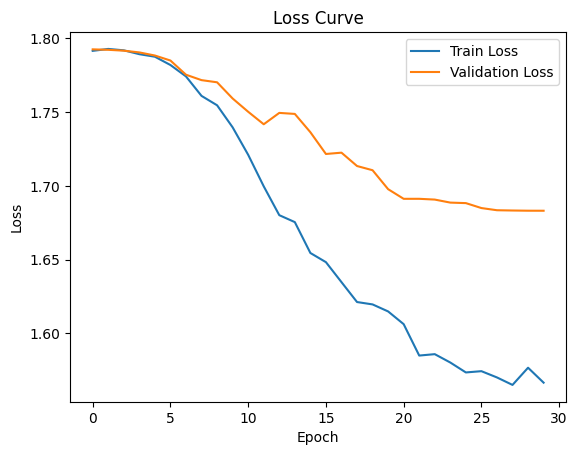

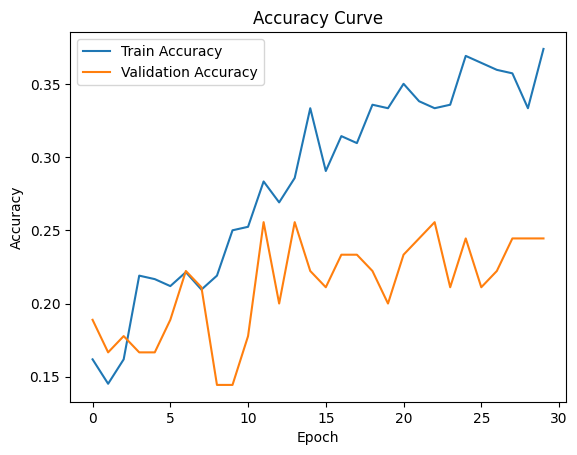

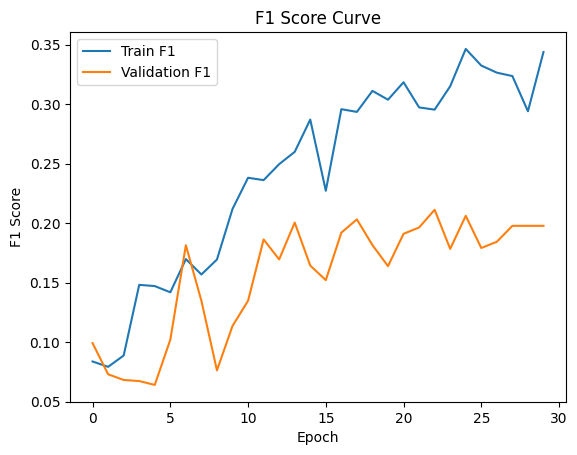

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7916,1.7926,0.1619,0.1889,0.0837,0.0991
1,2,1.7929,1.7923,0.1452,0.1667,0.0792,0.0729
2,3,1.7919,1.7917,0.1619,0.1778,0.0887,0.0682
3,4,1.7893,1.7905,0.2190,0.1667,0.1481,0.0672
4,5,1.7876,1.7884,0.2167,0.1667,0.1471,0.0640
5,6,1.7819,1.7850,0.2119,0.1889,0.1418,0.1020
6,7,1.7742,1.7754,0.2214,0.2222,0.1697,0.1814
7,8,1.7610,1.7717,0.2095,0.2111,0.1568,0.1346
8,9,1.7546,1.7702,0.2190,0.1444,0.1694,0.0762
9,10,1.7397,1.7592,0.2500,0.1444,0.2119,0.1135


In [8]:
num_layers = 1
use_skip_connections = False

experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# 1 layer, skip, GraphConv

Epoch 1/30
Train Loss: 1.7930 | Validation Loss: 1.8001
Train Acc: 0.1952 | Validation Acc: 0.1667
Train F1: 0.1316 | Validation F1: 0.0505

Epoch 2/30
Train Loss: 1.7940 | Validation Loss: 1.7987
Train Acc: 0.1810 | Validation Acc: 0.1667
Train F1: 0.1227 | Validation F1: 0.0505

Epoch 3/30
Train Loss: 1.7906 | Validation Loss: 1.7962
Train Acc: 0.1881 | Validation Acc: 0.1556
Train F1: 0.1319 | Validation F1: 0.0481

Epoch 4/30
Train Loss: 1.7844 | Validation Loss: 1.7920
Train Acc: 0.2119 | Validation Acc: 0.1778
Train F1: 0.1666 | Validation F1: 0.0974

Epoch 5/30
Train Loss: 1.7832 | Validation Loss: 1.7870
Train Acc: 0.2024 | Validation Acc: 0.2000
Train F1: 0.1608 | Validation F1: 0.1394

Epoch 6/30
Train Loss: 1.7706 | Validation Loss: 1.7818
Train Acc: 0.2357 | Validation Acc: 0.2667
Train F1: 0.2060 | Validation F1: 0.2014

Epoch 7/30
Train Loss: 1.7613 | Validation Loss: 1.7718
Train Acc: 0.2405 | Validation Acc: 0.2444
Train F1: 0.2015 | Validation F1: 0.1774

Epoch 8/30
Tr

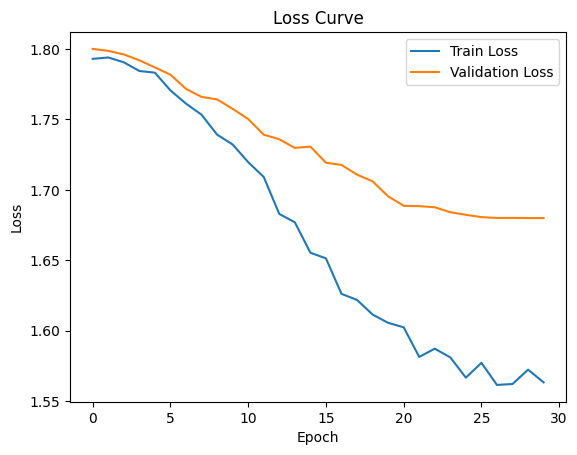

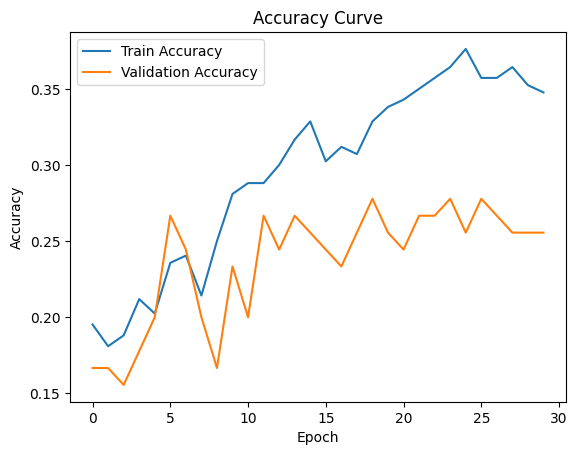

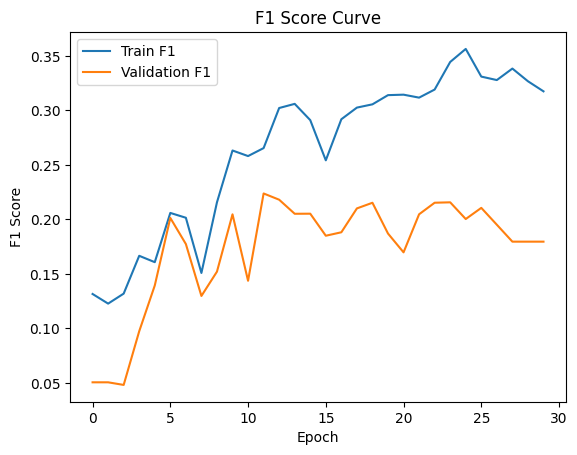

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7930,1.8001,0.1952,0.1667,0.1316,0.0505
1,2,1.7940,1.7987,0.1810,0.1667,0.1227,0.0505
2,3,1.7906,1.7962,0.1881,0.1556,0.1319,0.0481
3,4,1.7844,1.7920,0.2119,0.1778,0.1666,0.0974
4,5,1.7832,1.7870,0.2024,0.2000,0.1608,0.1394
5,6,1.7706,1.7818,0.2357,0.2667,0.2060,0.2014
6,7,1.7613,1.7718,0.2405,0.2444,0.2015,0.1774
7,8,1.7534,1.7661,0.2143,0.2000,0.1509,0.1298
8,9,1.7393,1.7642,0.2500,0.1667,0.2157,0.1521
9,10,1.7322,1.7576,0.2810,0.2333,0.2633,0.2047


In [9]:
num_layers = 1
use_skip_connections = True

experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# 2 layers, no skip, GraphConv

Epoch 1/30
Train Loss: 1.7918 | Validation Loss: 1.7921
Train Acc: 0.1738 | Validation Acc: 0.1667
Train F1: 0.0742 | Validation F1: 0.0476

Epoch 2/30
Train Loss: 1.7923 | Validation Loss: 1.7921
Train Acc: 0.1714 | Validation Acc: 0.1667
Train F1: 0.0803 | Validation F1: 0.0476

Epoch 3/30
Train Loss: 1.7918 | Validation Loss: 1.7919
Train Acc: 0.1690 | Validation Acc: 0.1667
Train F1: 0.0690 | Validation F1: 0.0476

Epoch 4/30
Train Loss: 1.7913 | Validation Loss: 1.7916
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.0705 | Validation F1: 0.0476

Epoch 5/30
Train Loss: 1.7915 | Validation Loss: 1.7910
Train Acc: 0.1762 | Validation Acc: 0.1667
Train F1: 0.0763 | Validation F1: 0.0476

Epoch 6/30
Train Loss: 1.7895 | Validation Loss: 1.7897
Train Acc: 0.1690 | Validation Acc: 0.1667
Train F1: 0.0855 | Validation F1: 0.0476

Epoch 7/30
Train Loss: 1.7830 | Validation Loss: 1.7826
Train Acc: 0.1929 | Validation Acc: 0.1444
Train F1: 0.1239 | Validation F1: 0.0563

Epoch 8/30
Tr

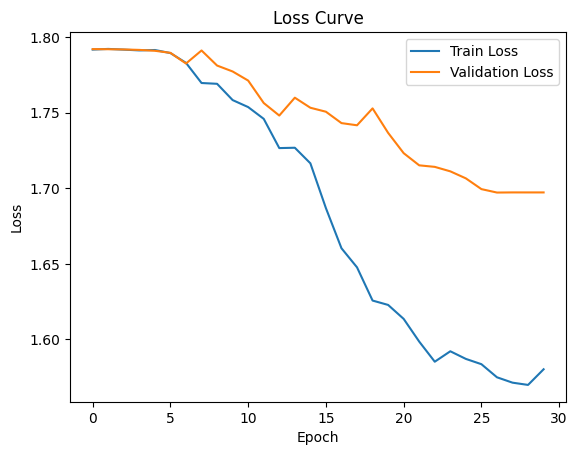

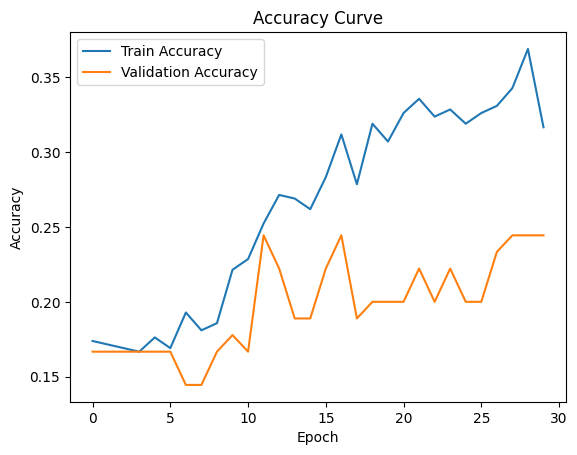

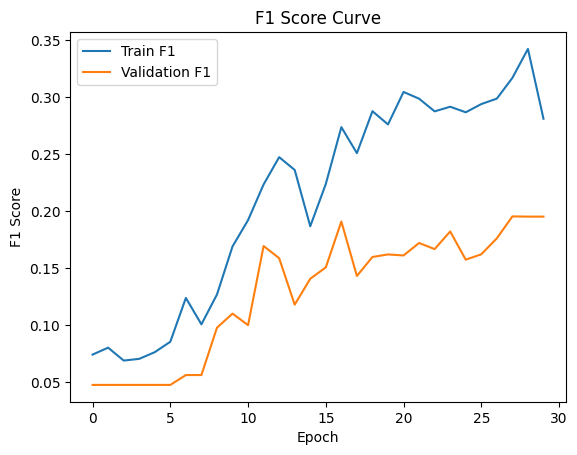

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7918,1.7921,0.1738,0.1667,0.0742,0.0476
1,2,1.7923,1.7921,0.1714,0.1667,0.0803,0.0476
2,3,1.7918,1.7919,0.1690,0.1667,0.0690,0.0476
3,4,1.7913,1.7916,0.1667,0.1667,0.0705,0.0476
4,5,1.7915,1.7910,0.1762,0.1667,0.0763,0.0476
5,6,1.7895,1.7897,0.1690,0.1667,0.0855,0.0476
6,7,1.7830,1.7826,0.1929,0.1444,0.1239,0.0563
7,8,1.7697,1.7912,0.1810,0.1444,0.1007,0.0563
8,9,1.7692,1.7813,0.1857,0.1667,0.1269,0.0977
9,10,1.7584,1.7773,0.2214,0.1778,0.1690,0.1101


In [10]:
num_layers = 2
use_skip_connections = False

experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# 2 layers, skip, GraphConv

Epoch 1/30
Train Loss: 1.8079 | Validation Loss: 1.7982
Train Acc: 0.1381 | Validation Acc: 0.1333
Train F1: 0.1022 | Validation F1: 0.0575

Epoch 2/30
Train Loss: 1.7913 | Validation Loss: 1.7967
Train Acc: 0.1833 | Validation Acc: 0.1333
Train F1: 0.1380 | Validation F1: 0.0600

Epoch 3/30
Train Loss: 1.7948 | Validation Loss: 1.7937
Train Acc: 0.1810 | Validation Acc: 0.1556
Train F1: 0.1341 | Validation F1: 0.0636

Epoch 4/30
Train Loss: 1.7908 | Validation Loss: 1.7896
Train Acc: 0.1833 | Validation Acc: 0.1667
Train F1: 0.1499 | Validation F1: 0.0963

Epoch 5/30
Train Loss: 1.7871 | Validation Loss: 1.7851
Train Acc: 0.1690 | Validation Acc: 0.1333
Train F1: 0.1523 | Validation F1: 0.1054

Epoch 6/30
Train Loss: 1.7786 | Validation Loss: 1.7794
Train Acc: 0.1738 | Validation Acc: 0.1778
Train F1: 0.1693 | Validation F1: 0.1011

Epoch 7/30
Train Loss: 1.7670 | Validation Loss: 1.7706
Train Acc: 0.1929 | Validation Acc: 0.2222
Train F1: 0.1760 | Validation F1: 0.1299

Epoch 8/30
Tr

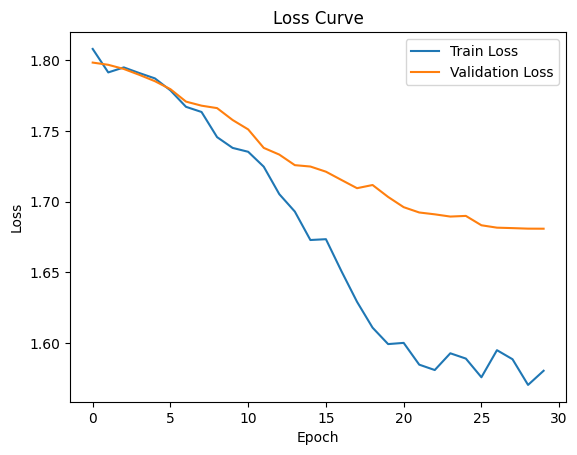

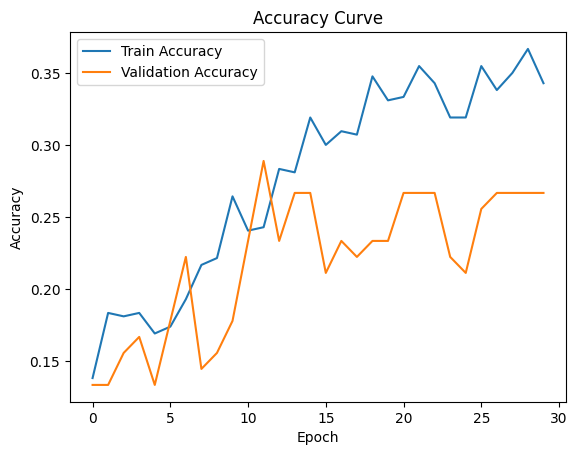

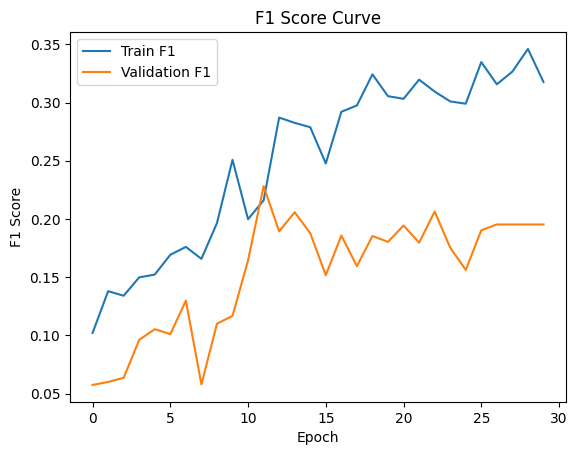

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8079,1.7982,0.1381,0.1333,0.1022,0.0575
1,2,1.7913,1.7967,0.1833,0.1333,0.1380,0.0600
2,3,1.7948,1.7937,0.1810,0.1556,0.1341,0.0636
3,4,1.7908,1.7896,0.1833,0.1667,0.1499,0.0963
4,5,1.7871,1.7851,0.1690,0.1333,0.1523,0.1054
5,6,1.7786,1.7794,0.1738,0.1778,0.1693,0.1011
6,7,1.7670,1.7706,0.1929,0.2222,0.1760,0.1299
7,8,1.7633,1.7678,0.2167,0.1444,0.1658,0.0580
8,9,1.7455,1.7660,0.2214,0.1556,0.1965,0.1101
9,10,1.7379,1.7576,0.2643,0.1778,0.2508,0.1168


In [11]:
num_layers = 2
use_skip_connections = True

experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# 3 layers, no skip, GraphConv

Epoch 1/30
Train Loss: 1.7913 | Validation Loss: 1.7918
Train Acc: 0.1905 | Validation Acc: 0.2000
Train F1: 0.0889 | Validation F1: 0.0981

Epoch 2/30
Train Loss: 1.7918 | Validation Loss: 1.7918
Train Acc: 0.1905 | Validation Acc: 0.1778
Train F1: 0.0894 | Validation F1: 0.0664

Epoch 3/30
Train Loss: 1.7917 | Validation Loss: 1.7917
Train Acc: 0.1833 | Validation Acc: 0.1778
Train F1: 0.0780 | Validation F1: 0.0664

Epoch 4/30
Train Loss: 1.7917 | Validation Loss: 1.7914
Train Acc: 0.1738 | Validation Acc: 0.1778
Train F1: 0.0695 | Validation F1: 0.0664

Epoch 5/30
Train Loss: 1.7915 | Validation Loss: 1.7911
Train Acc: 0.1952 | Validation Acc: 0.1778
Train F1: 0.1024 | Validation F1: 0.0664

Epoch 6/30
Train Loss: 1.7903 | Validation Loss: 1.7905
Train Acc: 0.1952 | Validation Acc: 0.1778
Train F1: 0.1015 | Validation F1: 0.0664

Epoch 7/30
Train Loss: 1.7891 | Validation Loss: 1.7887
Train Acc: 0.1833 | Validation Acc: 0.1778
Train F1: 0.0915 | Validation F1: 0.0664

Epoch 8/30
Tr

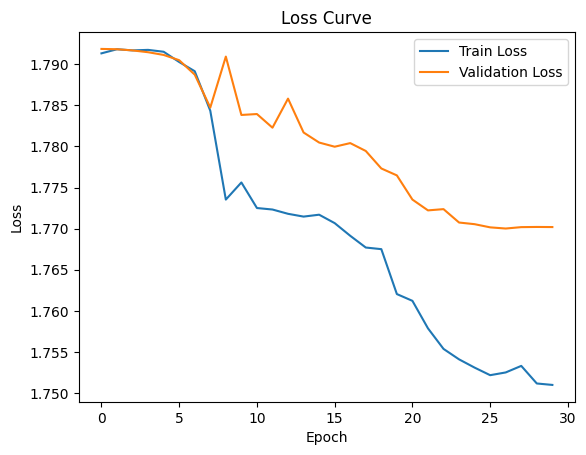

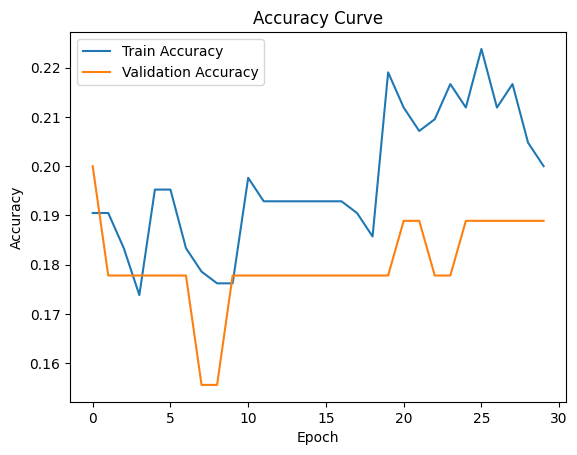

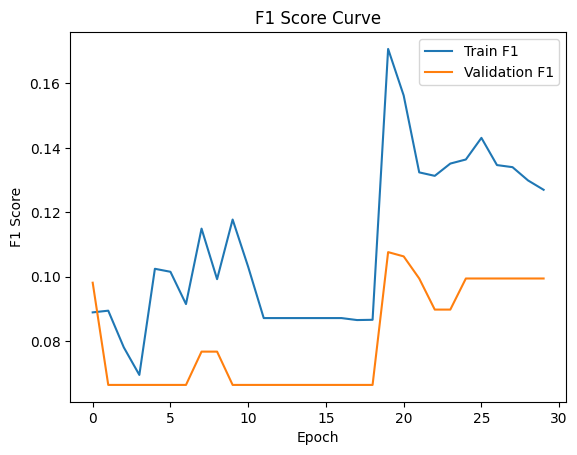

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7913,1.7918,0.1905,0.2000,0.0889,0.0981
1,2,1.7918,1.7918,0.1905,0.1778,0.0894,0.0664
2,3,1.7917,1.7917,0.1833,0.1778,0.0780,0.0664
3,4,1.7917,1.7914,0.1738,0.1778,0.0695,0.0664
4,5,1.7915,1.7911,0.1952,0.1778,0.1024,0.0664
5,6,1.7903,1.7905,0.1952,0.1778,0.1015,0.0664
6,7,1.7891,1.7887,0.1833,0.1778,0.0915,0.0664
7,8,1.7843,1.7847,0.1786,0.1556,0.1149,0.0767
8,9,1.7735,1.7909,0.1762,0.1556,0.0992,0.0767
9,10,1.7756,1.7838,0.1762,0.1778,0.1177,0.0664


In [12]:
num_layers = 3
use_skip_connections = False

experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# 3 layers, skip, GraphConv

Epoch 1/30
Train Loss: 1.7814 | Validation Loss: 1.7926
Train Acc: 0.1976 | Validation Acc: 0.1778
Train F1: 0.1591 | Validation F1: 0.0682

Epoch 2/30
Train Loss: 1.7897 | Validation Loss: 1.7922
Train Acc: 0.1548 | Validation Acc: 0.2000
Train F1: 0.1224 | Validation F1: 0.1097

Epoch 3/30
Train Loss: 1.7906 | Validation Loss: 1.7913
Train Acc: 0.1905 | Validation Acc: 0.1889
Train F1: 0.1520 | Validation F1: 0.0877

Epoch 4/30
Train Loss: 1.7899 | Validation Loss: 1.7900
Train Acc: 0.1619 | Validation Acc: 0.1778
Train F1: 0.1313 | Validation F1: 0.0841

Epoch 5/30
Train Loss: 1.7868 | Validation Loss: 1.7880
Train Acc: 0.1643 | Validation Acc: 0.1889
Train F1: 0.1379 | Validation F1: 0.1244

Epoch 6/30
Train Loss: 1.7827 | Validation Loss: 1.7854
Train Acc: 0.1762 | Validation Acc: 0.1667
Train F1: 0.1681 | Validation F1: 0.0935

Epoch 7/30
Train Loss: 1.7736 | Validation Loss: 1.7812
Train Acc: 0.1810 | Validation Acc: 0.1667
Train F1: 0.1698 | Validation F1: 0.0931

Epoch 8/30
Tr

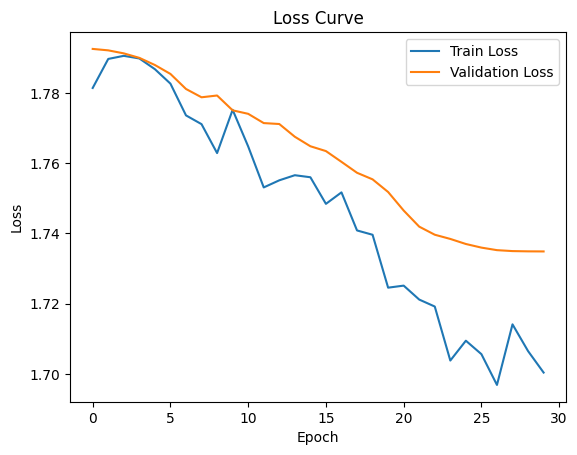

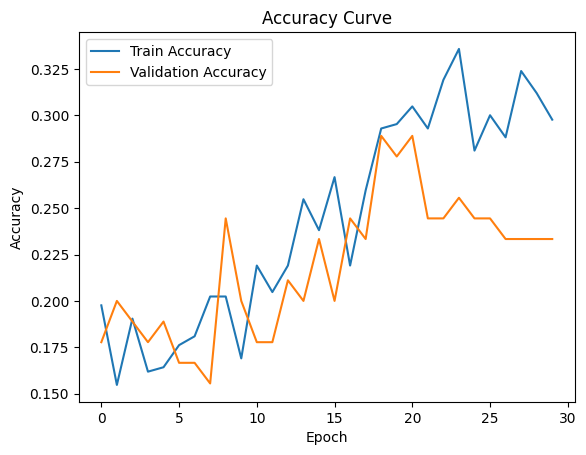

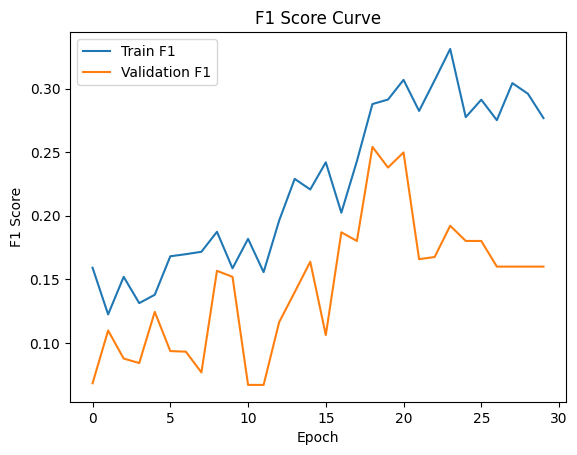

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7814,1.7926,0.1976,0.1778,0.1591,0.0682
1,2,1.7897,1.7922,0.1548,0.2000,0.1224,0.1097
2,3,1.7906,1.7913,0.1905,0.1889,0.1520,0.0877
3,4,1.7899,1.7900,0.1619,0.1778,0.1313,0.0841
4,5,1.7868,1.7880,0.1643,0.1889,0.1379,0.1244
5,6,1.7827,1.7854,0.1762,0.1667,0.1681,0.0935
6,7,1.7736,1.7812,0.1810,0.1667,0.1698,0.0931
7,8,1.7711,1.7788,0.2024,0.1556,0.1717,0.0767
8,9,1.7629,1.7793,0.2024,0.2444,0.1874,0.1567
9,10,1.7752,1.7751,0.1690,0.2000,0.1587,0.1519


In [13]:
num_layers = 3
use_skip_connections = True

experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)